In [1]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys
import numpy as np
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
class RedirectStdStreams(object):
    def __init__(self, stdout=None, stderr=None):
        self._stdout = stdout or sys.stdout
        self._stderr = stderr or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr

In [6]:
# take 32 pixels including c_x on each axis
def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop, None)

"""
    Get a 64x64 image around the nodule, when using random = false, we get the actual clip of the annotated nodule,
    when using random = true, get a 64x64 image around the nodule randomly chosen which may or may not show a part of the nodule
"""
def get_nodule_part(cbbox, random=False, shape=(32, 32), num_images=1):
    pct_shift = 0.3
    # extract 64x64 size images from the image randomly including the mask
    c_xs = [int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)]
    c_ys = [int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)]
    #print(c_x, c_y)
    if random: # random center within 64x64 box
#         c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
#         c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
        center_x = cbbox[0].start + int((cbbox[0].stop - cbbox[0].start)/2)
        center_y = cbbox[1].start + int((cbbox[1].stop - cbbox[1].start)/2)
        # 10% of the image width is the jitter boundary
        c_xs = np.random.choice(np.arange(center_x-int(shape[0]*pct_shift), center_x+int(shape[0]*pct_shift)), num_images, replace=False)
        c_ys = np.random.choice(np.arange(center_y-int(shape[1]*pct_shift), center_y+int(shape[1]*pct_shift)), num_images, replace=False)
    return [(get_stride(c_x, shape[0]), get_stride(c_y, shape[1]), cbbox[2]) for c_x, c_y in zip(c_xs, c_ys)]

"""
    Get a 64x64 image just outside the nodule bounding box 
"""
def get_outside_part(cbbox, random=False):
    # extract 64x64 size images from the image randomly including the mask
    c_x = int(cbbox[0].start + (cbbox[0].stop - cbbox[0].start)/2)
    c_y = int(cbbox[1].start + (cbbox[1].stop - cbbox[1].start)/2)
    #print(c_x, c_y)
    if random: # random center within 64x64 box
        c_x = np.random.choice(np.arange(cbbox[0].start, cbbox[0].stop))
        c_y = np.random.choice(np.arange(cbbox[1].start, cbbox[1].stop))
    return get_stride(c_x, shape[0]), get_stride(c_y, shape[0]), cbbox[2]

In [3]:
import matplotlib.patches as patches
# take 32 pixels including c_x on each axis
def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop)

def get_crops(boxes):
    crops = []
    if boxes:
        for box in boxes:
            x, y, w, h = box
            cx = int(x + w/2)
            cy = int(y + h/2)
            crops.append((get_stride(cy), get_stride(cx)))
    return crops
        
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [4]:
#code ref: https://github.com/JenifferWuUCLA/pulmonary-nodules-segmentation/blob/master/tianchi_segment_lung_ROI.ipynb
def preprocess_image(img):
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    #　to renormalize washed out images
    #middle = img[100:400, 100:400]
    middle = img
    mean = np.mean(middle)
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the
    #　underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    # Using Kmeans to separate foreground (radio-opaque tissue)
    #　and background (radio transparent tissue ie lungs)
    # Doing this only on the center of the image to avoid
    #　the non-tissue parts of the image as much as possible
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)  # threshold the image
    eroded = morphology.erosion(thresh_img, np.ones([4, 4]))
    dilation = morphology.dilation(eroded, np.ones([10, 10]))
    labels = measure.label(dilation)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0] < 475 and B[3]-B[1] < 475 and B[0] > 40 and B[2] < 472:
            good_labels.append(prop.label)

    mask = np.zeros_like(labels)
    for N in good_labels:
        mask = mask + np.where(labels == N, 1, 0)

    mask = morphology.dilation(mask, np.ones([10, 10]))  # one last dilation
    return img * mask

In [5]:
"""
    Select one negative sample, crops the same x, y slice from the volume on another z index that has no masks
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    random = when false will crop an image with nodule at center, when true will crop it wirh nodule slightly shifted randomly
    image_save = save the generated images
    image_plot = plot the generated images
    size = the size of the cropped image to return
"""
def select_another_slice(vol, slcz):
    idxs_after = np.arange(slcz.stop + 1, vol.shape[2])
    idxs_before = np.arange(0, slcz.start - 1)
    slices = []
    if len(idxs_after) > 10: # at least 10 more slices after the stop of the annotation box
        r = np.random.choice([2,3,4])
        slices.append(idxs_after[r])
    if len(idxs_before) > 10:
        sz = len(idxs_before)
        r = np.random.choice([sz-2,sz-3,sz-4])
        slices.append(idxs_before[r])
    if len(slices) <=0: # if this was towards the edge of the voxel
        slices.append(slcz.start)
    choice = np.random.choice(slices)
    return choice
def get_bounding_box_from_slice(s):
    x, y, z = s
    cx = int(x.start + (x.stop - x.start)/2)
    cy = int(y.start + (y.stop - y.start)/2)
    w = (x.stop - x.start)
    h = (y.stop - y.start)
    return (cx, cy, w, h)

def get_crops(boxes):
    crops = []
    if boxes:
        for box in boxes:
            x, y, w, h = box
            cx = int(x + w/2)
            cy = int(y + h/2)
            crops.append((get_stride(cx), get_stride(cy)))
    return crops

"""
    Get one negative sample for this patient per nodule
"""
def save_negative_sample(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, random=False, 
                            image_save=False, image_plot=True, size=(64,64)):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
    
    slcz = bounding_box[nodule_number][2]
    selected_slice = select_another_slice(vol, slcz)
    box = get_bounding_box_from_slice(bounding_box[nodule_number])
    #the functions works on an arrays, get a 64x64 cropped image
    crops = get_crops([box])
    if len(crops) < 1:
        return
    crop = crops[0]
    
    fullimg = vol[:,:,selected_slice]
    #save and reload
    try:
        imageio.imwrite('/data/unet/temp/temp_img.jpg', fullimg)
        disk_img = cv2.imread('/data/unet/temp/temp_img.jpg')
    except:
        return
    im = cv2.cvtColor(disk_img, cv2.COLOR_BGR2GRAY)
    img_t = preprocess_image(im)
    cropped_img = img_t[crop[0],crop[1]]
    mask = CT_mask[crop[0],crop[1],selected_slice]
    
    #img = vol[crop[0],crop[1],selected_slice]
    
    if cropped_img.shape != (size[0], size[1]):
        print("Cropped image size", cropped_img.shape)
        return
    if mask.shape != (size[0], size[1]):
        print("Mask size", mask.shape)
        return
    if len(np.unique(mask)) > 1:
        print("Mask length", len(np.unique(mask)))
        return
    
    if image_save:
        image_file_name = "img_out_{}_{}_{}.jpg".format(patient_id, nodule_number, selected_slice)
        mask_file_name = "mask_out_{}_{}_{}.jpg".format(patient_id, nodule_number, selected_slice)
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            imageio.imwrite(image_dir + image_file_name, cropped_img)
        with RedirectStdStreams(stdout=devnull, stderr=devnull):    
            imageio.imwrite(mask_dir + mask_file_name, mask)
    if image_plot:
        f, a =  plt.subplots(1,2, figsize=(8,10))
        a[0].imshow(cropped_img, 'bone')
        a[0].set_title("img_out_{}_{}_{}.jpg".format(patient_id, nodule_number, selected_slice))
        a[1].imshow(mask, 'bone')
        plt.show()

In [37]:
"""
    Save the image of the slice after preprocessing, saves on image per slice with annotations
    root_dir: where to save the generated images
    patient_id = id of the patient
    bounding_box = array of slices per nodule
    nodule_number = the nodule to process
    vol = the DICOM image
    CT_mask = the mask from the DICOM image
    image_save = save the generated images
    image_plot = plot the generated images
"""
def save_image_foreach_slice(root_dir, patient_id, bounding_box, nodule_number, vol, CT_mask, image_save=False, image_plot=True, size=(64, 64)):
    devnull = open(os.devnull, 'w')
    if image_save:
        assert os.path.exists(root_dir)
        image_dir = root_dir + '/images/'
        mask_dir = root_dir + '/masks/'
        label_dir = root_dir + '/labels/'
        assert os.path.exists(image_dir)
        assert os.path.exists(mask_dir)
        assert os.path.exists(label_dir)
        
    slcz = bounding_box[nodule_number][2]
    unique_slice_ids = np.arange(slcz.start, slcz.stop)
    cnt = 0
    for unique_slice_id in unique_slice_ids:
        fullimg = vol[:,:,unique_slice_id]
        #save and reload
        try:
            imageio.imwrite('/data/unet/temp/temp_img.jpg', fullimg)
            disk_img = cv2.imread('/data/unet/temp/temp_img.jpg')
        except:
            continue
        im = cv2.cvtColor(disk_img, cv2.COLOR_BGR2GRAY)
        img = preprocess_image(im)
        #img = preprocess_image(fullimg)
        mask = CT_mask[:,:,unique_slice_id]
        if img.shape != (size[0], size[1]):
            continue
        if mask.shape != (size[0], size[1]):
            continue
        if image_save:
            if random:
                image_file_name = "img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            else:
                image_file_name = "img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
                mask_file_name = "mask_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(image_dir + image_file_name, img)
            with RedirectStdStreams(stdout=devnull, stderr=devnull):
                imageio.imwrite(mask_dir + mask_file_name, mask)
                
                
        #save the labels for Yolo training (Yolov5 pytorch format)
        if image_save:
            boxes = get_bounding_box(mask)
            if boxes:
                for box in boxes:
                    x, y, w, h = box
                    #drop small objects
                    if (w <= 3) or (h <= 3):
                        continue
                    center_x = (x + ((w)/2))/vol[:,:,unique_slice_id].shape[0]
                    center_y = (y + ((h)/2))/vol[:,:,unique_slice_id].shape[1]
                    width = w/vol[:,:,unique_slice_id].shape[0]
                    height = h/vol[:,:,unique_slice_id].shape[1]

                    c = 0 # there is only one class, the 'nodule'
                    # save this as the label for the image for the YoloV5 object detection training
                    #print("Yolov5 formatted labels are = {} {} {} {} {}".format(c, center_x, center_y, width, height))
                    label = "{} {} {} {} {}".format(c, center_x, center_y, width, height)
                    label_filename = "{}_{}_{}.txt".format(patient_id, nodule_number, unique_slice_id)
                    f = open(label_dir + "/" + label_filename, "a")
                    f.write(label + "\n")
                    f.close()
            else:
                # save this as the label for the image for the YoloV5 object detection training
                label_filename = "{}_{}_{}.txt".format(patient_id, nodule_number, unique_slice_id)
                f = open(label_dir + "/" + label_filename, "a")
                f.write("")
                f.close()
            
        if image_plot:
            
            boxes = get_bounding_box(mask)
            if boxes:
                for box in boxes:
                    x, y, w, h = box
                    #drop small objects
                    if (w <= 3) or (h <= 3):
                        continue
                    center_x = (x + ((w)/2))/vol[:,:,unique_slice_id].shape[0]
                    center_y = (y + ((h)/2))/vol[:,:,unique_slice_id].shape[1]
                    width = w/vol[:,:,unique_slice_id].shape[0]
                    height = h/vol[:,:,unique_slice_id].shape[1]

                    c = 0 # there is only one class, the 'nodule'
                    # save this as the label for the image for the YoloV5 object detection training
                    #print("Yolov5 formatted labels are = {} {} {} {} {}".format(c, center_x, center_y, width, height))
                    label = "{} {} {} {} {}".format(c, center_x, center_y, width, height)
                    label_map = "{} {} {} {} {}".format(c, center_x*512, center_y*512, width*512, height*512)
                    label_filename = "{}_{}_{}.txt".format(patient_id, nodule_number, unique_slice_id)
                    print("Label is {} for {} and absolute {}".format(label, label_filename, label_map))
            else:
                # save this as the label for the image for the YoloV5 object detection training
                label_filename = "{}_{}_{}.txt".format(patient_id, nodule_number, unique_slice_id)
                print("Label is {} for {}".format(label, label_filename))
                
                
                
            cnt += 1
            f, a =  plt.subplots(1,2, figsize=(8,10))
            a[0].imshow(img)
            if random:
                a[0].set_title("img_random_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            else:
                a[0].set_title("img_{}_{}_{}.jpg".format(patient_id, nodule_number, unique_slice_id))
            a[1].imshow(mask)
            plt.show()
    if image_plot:
        print("Saved {} images".format(cnt))

In [35]:
def un(a, b):
    return np.union1d(a, b)

def unr(ll, acc, i):
    if i < len(ll):
        j = i + 1
        acc = un(ll[i], acc)
        return unr(ll, acc, j)
    else:
        return acc

def get_slices_with_masks(cbbox_CT):
    ll = []
    for cb in cbbox_CT:
        ll.append(np.arange(cb[2].start, cb[2].stop+1))
    return unr(ll, [], 0)

def load_patient_vol_and_mask(dicom_dir, patient_id=-1):
    #supress the stdout and stderr
    devnull = open(os.devnull, 'w')
    
    f = open ('/root/.pylidcrc','w')
    f.write('[dicom]'+'\n')
    f.write('path =' + dicom_dir +'\n')
    f.write('warn = True')
    f.close()
    
    patient_list = os.listdir(dicom_dir)
    if patient_id == -1: #select one randomly
        patient_id = np.random.choice(patient_list)
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    vol = None
    try:
        with RedirectStdStreams(stdout=devnull, stderr=devnull):
            vol = scan.to_volume()
    except:
        print("Error loading DICOM for patient {}".format(patient_id))
        return None, None, None, None
    # are there nodules that are useful?

    # process the mask for the image
    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        if len(nodule) >= 2:
            cmask, cbbox, masks = consensus(nodule)
            cmask_CT.append(cmask)
            cbbox_CT.append(cbbox)
            masks_CT.append(masks)

    if len(cbbox_CT) <=0:
        #print("No relevant nodules for patient {}".format(patient_id))
        return None, None, None, None


    # create the mask voxel
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    #print("Number of nodules {}".format(nodule_num))
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask

    # get the slices that have annotations
    slices_with_mask = get_slices_with_masks(cbbox_CT)
    
    return vol, CT_mask, cbbox_CT, slices_with_mask

Lossy conversion from int16 to uint8. Range [-1024, 1051]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2490234375 0.4013671875 0.078125 0.1015625 for LIDC-IDRI-0284_0_57.txt and absolute 0 127.5 205.5 40.0 52.0


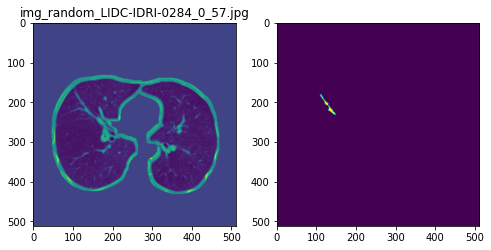

Lossy conversion from int16 to uint8. Range [-1024, 1170]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2431640625 0.3984375 0.06640625 0.091796875 for LIDC-IDRI-0284_0_58.txt and absolute 0 124.5 204.0 34.0 47.0


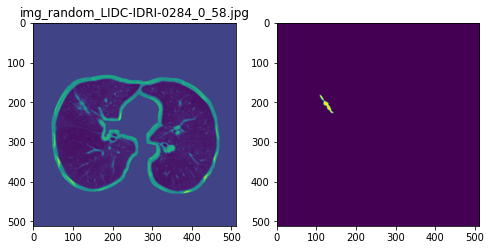

Lossy conversion from int16 to uint8. Range [-1024, 1094]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2392578125 0.3994140625 0.06640625 0.08984375 for LIDC-IDRI-0284_0_59.txt and absolute 0 122.5 204.5 34.0 46.0


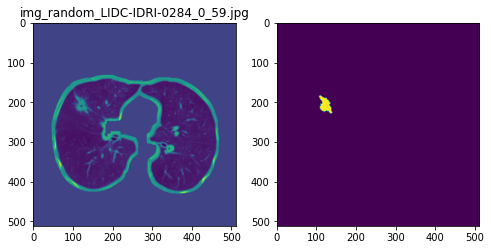

Lossy conversion from int16 to uint8. Range [-1024, 926]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2373046875 0.4013671875 0.0703125 0.08203125 for LIDC-IDRI-0284_0_60.txt and absolute 0 121.5 205.5 36.0 42.0


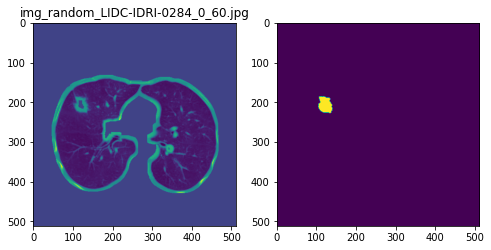

Lossy conversion from int16 to uint8. Range [-1024, 910]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2353515625 0.4052734375 0.08203125 0.08984375 for LIDC-IDRI-0284_0_61.txt and absolute 0 120.5 207.5 42.0 46.0


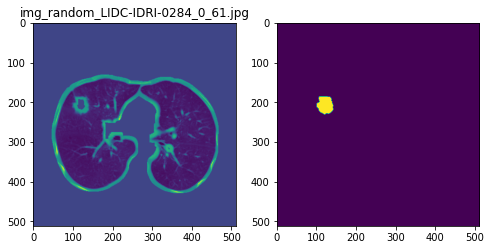

Lossy conversion from int16 to uint8. Range [-1024, 873]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2333984375 0.4052734375 0.08984375 0.09765625 for LIDC-IDRI-0284_0_62.txt and absolute 0 119.5 207.5 46.0 50.0


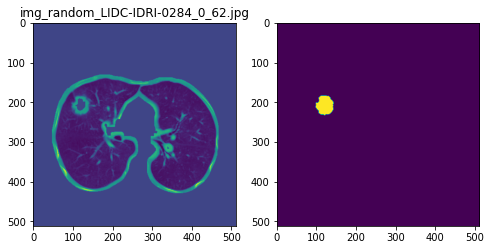

Lossy conversion from int16 to uint8. Range [-1024, 906]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2333984375 0.408203125 0.10546875 0.107421875 for LIDC-IDRI-0284_0_63.txt and absolute 0 119.5 209.0 54.0 55.0


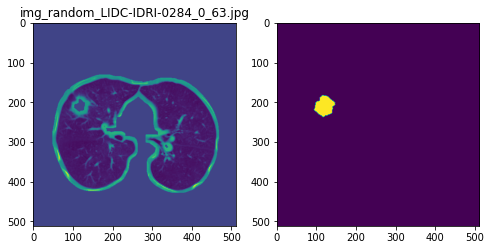

Lossy conversion from int16 to uint8. Range [-1024, 933]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2275390625 0.4091796875 0.109375 0.09765625 for LIDC-IDRI-0284_0_64.txt and absolute 0 116.5 209.5 56.0 50.0


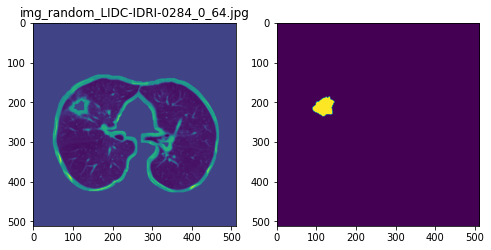

Lossy conversion from int16 to uint8. Range [-1024, 1083]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2236328125 0.4140625 0.10546875 0.087890625 for LIDC-IDRI-0284_0_65.txt and absolute 0 114.5 212.0 54.0 45.0


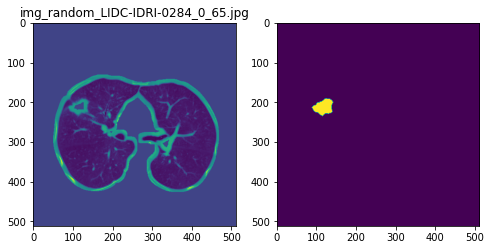

Lossy conversion from int16 to uint8. Range [-1024, 1294]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2216796875 0.412109375 0.09375 0.076171875 for LIDC-IDRI-0284_0_66.txt and absolute 0 113.5 211.0 48.0 39.0


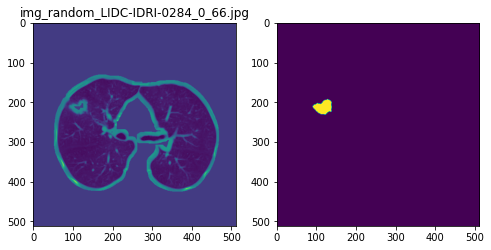

Lossy conversion from int16 to uint8. Range [-1024, 1109]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.2197265625 0.41796875 0.08203125 0.064453125 for LIDC-IDRI-0284_0_67.txt and absolute 0 112.5 214.0 42.0 33.0


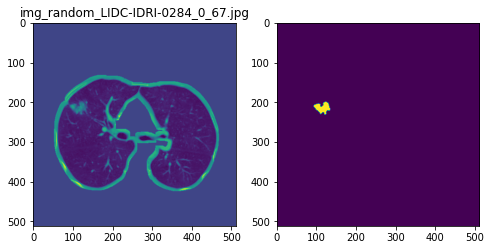

Lossy conversion from int16 to uint8. Range [-1024, 1110]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.1923828125 0.4111328125 0.0234375 0.01171875 for LIDC-IDRI-0284_0_68.txt and absolute 0 98.5 210.5 12.0 6.0


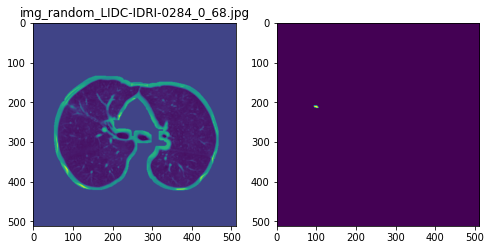

Lossy conversion from int16 to uint8. Range [-1024, 1110]. Convert image to uint8 prior to saving to suppress this warning.


Label is 0 0.1923828125 0.4111328125 0.0234375 0.01171875 for LIDC-IDRI-0284_0_69.txt


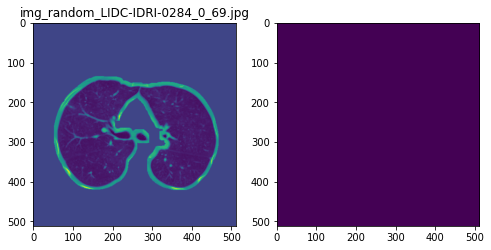

Saved 13 images


In [38]:
vol, CT_mask, cbbox, slices_with_mask = load_patient_vol_and_mask('/data/yolov5/test/sorted_gcsfiles', 'LIDC-IDRI-0436')
save_image_foreach_slice(root_dir='/data/unet/train/', patient_id='LIDC-IDRI-0284', bounding_box=cbbox, nodule_number=0,  
                         vol=vol, CT_mask=CT_mask, image_save=False, image_plot=True, size=(512,512))